https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras/notebook

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import string
from collections import Counter
from time import time
import pickle

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

In [2]:
# Load training and testing text
train = pd.read_csv('train.csv', skiprows=1, names=['ID', 'Text', 'Author']).set_index('ID')
test = pd.read_csv('test.csv', skiprows=1, names=['ID', 'Text']).set_index('ID')

# Delete the word 'id' from the ID columns
train.index = [id[2:] for id in train.index]
test.index = [id[2:] for id in test.index]

In [4]:
# unpickle the final model
file = open('spooky_train_vec.pkl', 'rb')
train_vec=pickle.load(file)
file.close()

In [5]:
# Transform labels into one hot encoded format.
y_train_ohe = label_binarize(train['Author'], classes=['EAP', 'HPL', 'MWS'])
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])

y_train_ohe shape: (19579, 3)
y_train_ohe samples:
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


In [6]:
# If using spaCy word vectors
X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (15663, 128)
X_test size: (3916, 128)
y_train size: (15663, 3)
y_test size: (3916, 3)


In [22]:
def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=128))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(128,1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(3, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(128,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        outputs = Dense(3, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

In [23]:
# Define keras model
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

In [24]:
# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_test.shape)
    print('Text test shape: ', X_test.shape)
else:
    print('not using CNN or LSTM')

not using CNN or LSTM


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
__________

In [26]:
# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

Now we train the model on our train/test set and also include the parameter 'val_split' as 0.2 which takes 20% of the training data and turns it into a validation set.

In [27]:
# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 12530 samples, validate on 3133 samples
Epoch 1/50
12530/12530 [==============================] - 6s 467us/step - loss: 9.4480 - acc: 0.4031 - val_loss: 9.7604 - val_acc: 0.3939
Epoch 2/50
12530/12530 [==============================] - 4s 344us/step - loss: 9.5781 - acc: 0.4048 - val_loss: 9.7604 - val_acc: 0.3939
Epoch 3/50
12530/12530 [==============================] - 4s 328us/step - loss: 9.5781 - acc: 0.4048 - val_loss: 9.7605 - val_acc: 0.3939
Epoch 4/50
12530/12530 [==============================] - 3s 272us/step - loss: 9.5781 - acc: 0.4048 - val_loss: 9.7604 - val_acc: 0.3939
Epoch 5/50
12530/12530 [==============================] - 5s 382us/step - loss: 9.5781 - acc: 0.4048 - val_loss: 9.7604 - val_acc: 0.3939
Epoch 6/50
12530/12530 [==============================] - 4s 334us/step - loss: 9.5781 - acc: 0.4048 - val_loss: 9.7604 - val_acc: 0.3939
Epoch 7/50
12530/12530 [==============================] - 8s 616us/step - l

In [28]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 40.48% / Validation accuracy: 39.39%


C:\Users\alasseter\AppData\Local\Continuum\anaconda3\envs\keras-env\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\alasseter\AppData\Local\Continuum\anaconda3\envs\keras-env\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


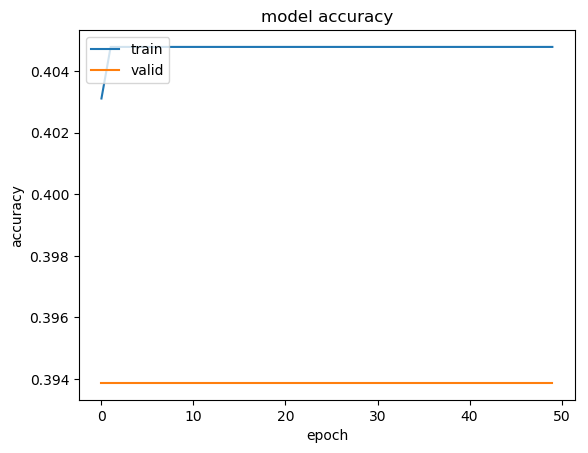

In [29]:
# Plot model accuracy over epochs
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

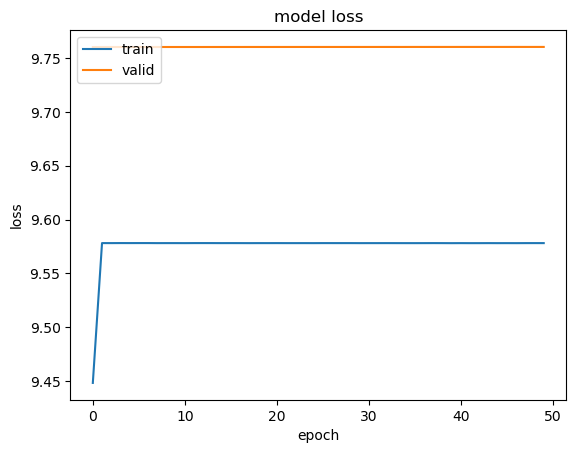

In [30]:
# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Using spaCy word vectors
For MLP architecture: From the plot above we can see the model starts to overfit the training data early around the fifth epoch. The validation accuracy stays stable for the rest of the training and the loss goes up as training goes on.

For CNN architecture: Both the training and validation accuracy go up as training goes on. The loss also goes down continuously. With more epochs the loss would probably continue to go down until eventually saturating. Some more parameter tweaking and could also lead to a lower log loss score.

For LSTM architecture: The training accuracy is 58.90% and the validation accuracy is 58.60%. From the model accuracy plot above we can see both accuracies rise and continue to rise until the final epoch. The model losses also go down continuously indicating that more epochs will lead to a better performance.

In [32]:
# Make predictions
predicted_prob = model.predict(X_test)
print(predicted_prob.shape)

(3916, 3)


In [35]:
# Report log loss and score
loss_sk = log_loss(y_test, predicted_prob)
print('Log loss is: {}'.format(loss_sk))

Log loss is: 20.421391948951033


#### Using spaCy word vectors
The log loss for the MLP architecture is about 1.1416 which is not too bad, but can definitely be improved with parameter tweaking (number of neurons, number of layers, kernel initialization, dropout rate, etc.).

Meanwhile the log loss for the CNN architecture is about 0.952 and is an improvement over the basic MLP architecture. Again, parameter tweaking will probably lead to better results and although CNNs perform well on computer vision problems they also have a lot of uses in natural language processing.

However a lot of times recurrent neural networks (RNN), in particular long short term memory (LSTM), produce the best results. Using a LSTM architecture, the model acheived a log loss score of 0.9303. This is the best score out of all three architectures. This was also using only one hidden layer which was a bidirectional lstm layer with 64 memory units. Adding more memory units and layers and tweaking the dropout rate will probably lead to better results. Increasing the number of epochs will also lead to better results however it will increase the training time.

Here are some useful links to learn more about neural networks and their uses for natural language processing:

Primer on nerual networks and NLP: https://arxiv.org/abs/1510.00726

Understanding LSTM networks: http://colah.github.io/posts/2015-08-Understanding-LSTMs/